In [8]:
from qiskit_ibm_runtime.fake_provider import FakeVigo
device_backend = FakeVigo()

/tmp/ipykernel_204/2647586769.py:2: DeprecationWarning: V1 fake backends are deprecated as of qiskit-ibm-runtime 0.24 and will be removed no sooner than 3 months after the release date. Please use V2 fake backends instead.
  device_backend = FakeVigo()


Note: you may need to restart the kernel to use updated packages.


/tmp/ipykernel_204/1134976542.py:10: DeprecationWarning: V1 fake backends are deprecated as of qiskit-ibm-runtime 0.24 and will be removed no sooner than 3 months after the release date. Please use V2 fake backends instead.
  backend = FakeVigo()
/tmp/ipykernel_204/1134976542.py:11: DeprecationWarning:  from_backend using V1 based backend is deprecated as of Aer 0.15 and will be removed no sooner than 3 months from that release date. Please use backends based on V2.
  noise_model = NoiseModel.from_backend(backend)


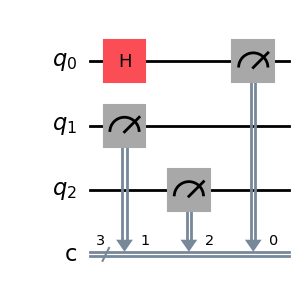

In [12]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from qiskit_aer.noise import NoiseModel
from qiskit_ibm_runtime.fake_provider import FakeVigoV2
%pip install pylatexenc


# Build noise model from backend properties
backend = FakeVigo()
noise_model = NoiseModel.from_backend(backend)

# Get coupling map from backend
coupling_map = backend.configuration().coupling_map

# Get basis gates from noise model
basis_gates = noise_model.basis_gates

# Make a circuit
circ = QuantumCircuit(3, 3)
circ.h(0) # Creates 50 / 50 for 0 or 1
circ.measure([0, 1, 2], [0, 1, 2])
circ.draw('mpl')

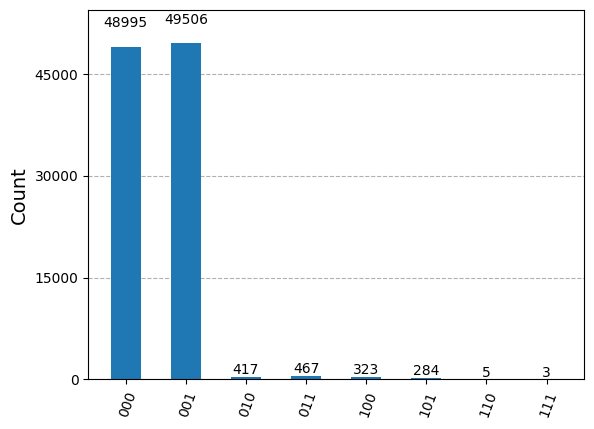

In [26]:
# Perform a noise simulation
backend = AerSimulator(noise_model=noise_model,
                       coupling_map=coupling_map,
                       basis_gates=basis_gates,
                      shots=100000)
transpiled_circuit = transpile(circ, backend)
result = backend.run(transpiled_circuit).result()

counts = result.get_counts(0)
plot_histogram(counts)

Note: you may need to restart the kernel to use updated packages.


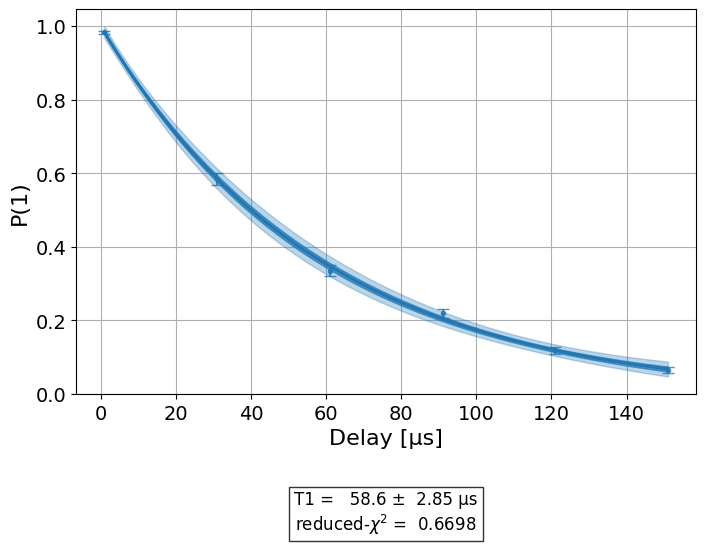

AnalysisResult
- name: @Parameters_T1Analysis
- value: CurveFitResult:
 - fitting method: least_squares
 - number of sub-models: 1
  * F_exp_decay(x) = amp * exp(-x/tau) + base
 - success: True
 - number of function evals: 20
 - degree of freedom: 3
 - chi-square: 2.0093912890354275
 - reduced chi-square: 0.6697970963451425
 - Akaike info crit.: -0.5635658057919404
 - Bayesian info crit.: -1.188287398107775
 - init params:
  * amp = 0.9170731707317072
  * tau = 5.607702037182498e-05
  * base = 0.06585365853658537
 - fit params:
  * amp = 1.0086868600903047 ± 0.015516360501051657
  * tau = 5.8570508695457946e-05 ± 2.8452247945946906e-06
  * base = -0.008900903510283954 ± 0.015635835578484483
 - correlations:
  * (amp, base) = -0.9367372953395972
  * (tau, base) = -0.9216265226658653
  * (amp, tau) = 0.825232200074041
- quality: good
- extra: <3 items>
- device_components: ['Q0']
- verified: False
AnalysisResult
- name: T1
- value: (5.86+/-0.28)e-05
- χ²: 0.6697970963451425
- quality: go

In [27]:
# Measuring how long it takes a qubit to go to the ground state
import numpy as np
%pip install qiskit-experiments
from qiskit.qobj.utils import MeasLevel
from qiskit_experiments.framework import ParallelExperiment
from qiskit_experiments.library import T1
from qiskit_experiments.library.characterization.analysis.t1_analysis import T1KerneledAnalysis

# A T1 simulator
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel
from qiskit_ibm_runtime.fake_provider import FakePerth

# A kerneled data simulator
from qiskit_experiments.test.mock_iq_backend import MockIQBackend
from qiskit_experiments.test.mock_iq_helpers import MockIQT1Helper

# Create a pure relaxation noise model for AerSimulator
noise_model = NoiseModel.from_backend(
    FakePerth(), thermal_relaxation=True, gate_error=False, readout_error=False
)

# Create a fake backend simulator
backend = AerSimulator.from_backend(FakePerth(), noise_model=noise_model)

# Look up target T1 of qubit-0 from device properties
qubit0_t1 = FakePerth().qubit_properties(0).t1

# Time intervals to wait before measurement
delays = np.arange(1e-6, 3 * qubit0_t1, 3e-5)
# Create an experiment for qubit 0
# with the specified time intervals
exp = T1(physical_qubits=(0,), delays=delays)

# Set scheduling method so circuit is scheduled for delay noise simulation
exp.set_transpile_options(scheduling_method='asap')

# Run the experiment circuits and analyze the result
exp_data = exp.run(backend=backend, seed_simulator=101).block_for_results()

# Print the result
display(exp_data.figure(0))
for result in exp_data.analysis_results():
    print(result)